In [40]:
# Import the necessary information
%store -r louisa_gdf site_dir data_dir

In [41]:
louisa_gdf

,Loc_Nm,geometry
28,Port Louisa National Wildlife Refuge,"MULTIPOLYGON (((-91.10656 41.13155, -91.10656 ..."
56,Port Louisa National Wildlife Refuge,"MULTIPOLYGON (((-91.10655 41.13335, -91.10657 ..."


In [42]:
### Import necessary packages
import earthaccess

### Reproducable file paths
import os
from glob import glob
import pathlib

### Managing spatial data
import geopandas as gpd
import xrspatial
import xarray as xr
import rioxarray
import rioxarray.merge as rxrmerge


### Managing other types of data
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rmrm
from math import floor, ceil
import matplotlib.pyplot as plt
from rasterio.merge import merge as merge_arrays
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rioxarray.merge import merge_arrays


### Manage invalid geometries
from shapely.geometry import MultiPolygon, Polygon

### Visualizing data
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

from math import floor, ceil
import matplotlib.pyplot as plt

import warnings

In [43]:
# Download elevation data
# Define data directory for 
louisa_elevation_dir = os.path.join(data_dir, 'louisa_elevation_strm')

os.makedirs(louisa_elevation_dir, exist_ok=True)

OPENED 
CROPPED
OPENED 
CROPPED


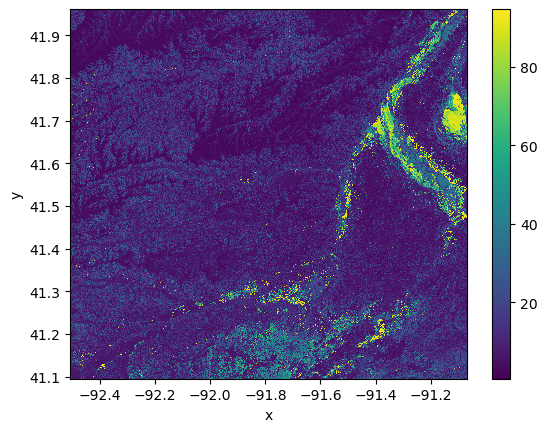

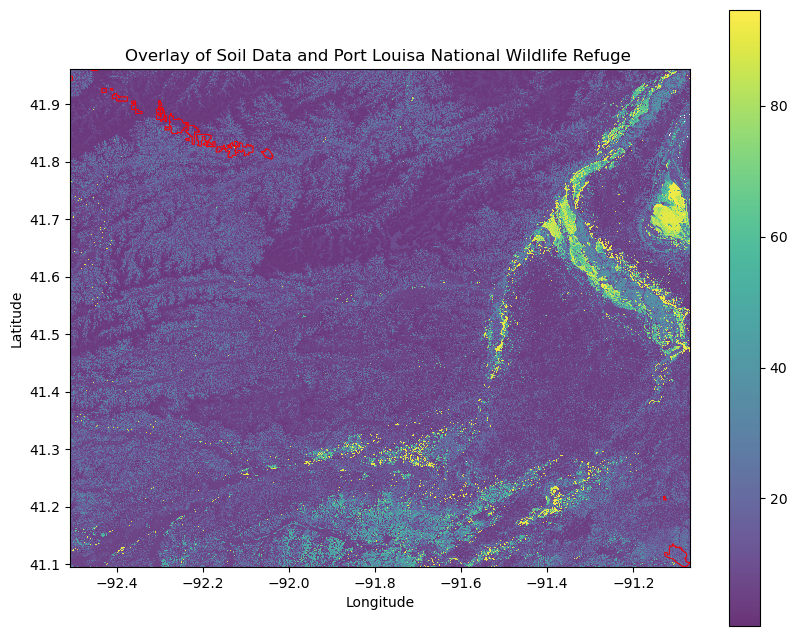

In [46]:
# Download soil data for Port Louisa National Wildlife Refuge
# Define the download URL for the study area (Polaris Data). 
louisa_soil_url_template = ("http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/sand"
            "/mean"
            "/60_100/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)

louisa_soil_url = louisa_soil_url_template.format(
    min_lat=41.1, max_lat=42, min_lon=-91.0, max_lon=-92.5  
)

louisa_soil_url

#Define Bounds for Port Louisa
louisa_bounds = bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    louisa_gdf.total_bounds)

louisa_soil_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        louisa_soil_url = louisa_soil_url_template.format(
            min_lat=min_lat, max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1)
        louisa_soil_url_list.append(louisa_soil_url)
louisa_soil_url_list

louisa_soil_das = []

#loop through each of the soil files
for i in louisa_soil_url_list:
     # Load the raster data into Python, mask and scale and squeeze
    louisa_soil_da = rxr.open_rasterio(
         i,
         mask_and_scale=True
         ).squeeze()
    print('OPENED ')

    # Crop the raster data
    louisa_cropped_da = louisa_soil_da.rio.clip_box(*louisa_bounds) 
    louisa_soil_das.append(louisa_cropped_da)
    print('CROPPED')

#     # Merge tiles

# Function to convert xarray DataArray to rasterio dataset
def dataarray_to_rasterio(da):
    """Convert an xarray DataArray to a rasterio dataset stored in MemoryFile."""
    height, width = da.shape
    transform = from_bounds(*da.rio.bounds(), width, height)
    crs = da.rio.crs

    memfile = MemoryFile()
    with memfile.open(
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=da.dtype,
        crs=crs,
        transform=transform,
    ) as dataset:
        dataset.write(da.values, 1)

    return memfile.open()

# Convert all DataArrays to rasterio datasets
rasterio_datasets = [dataarray_to_rasterio(da) for da in louisa_soil_das]

# Merge using rasterio
merged_array, merged_transform = merge(rasterio_datasets)

# Ensure `y` axis is in correct order
y_coords = np.linspace(merged_transform.f, merged_transform.f + merged_array.shape[1] * merged_transform.e, merged_array.shape[1])
x_coords = np.linspace(merged_transform.c, merged_transform.c + merged_array.shape[2] * merged_transform.a, merged_array.shape[2])

# Correct CRS and Assign Transform
louisa_soil_merged_das = xr.DataArray(
    merged_array[0],  # Use the first band
    dims=("y", "x"),
    coords={"y": y_coords[::-1], "x": x_coords},  # Flip y-coordinates to correct orientation
    attrs={"crs": rasterio_datasets[0].crs, "transform": merged_transform}
)

# Plot merged raster
louisa_soil_merged_das.plot()

# # Create a plot
louisa, ax = plt.subplots(figsize=(10, 8))

# Plot the raster data (louisa_soil_das)
louisa_soil_merged_das.plot(ax=ax, cmap="viridis", alpha=0.8)  # Adjust alpha for transparency

# Plot the boundaries of the vector data (louisa_gdf)
louisa_gdf.boundary.plot(ax=ax, color='red', linewidth=.5)

# Add title and labels
ax.set_title("Overlay of Soil Data and Port Louisa National Wildlife Refuge ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [47]:
# Define data search for Port Louisa National Wildlife refuge Ridge
louisa_srtm_pattern = os.path.join(louisa_elevation_dir, '*.hgt.zip') 

# Define bounds for PLNWR
bounds_louisa = tuple(louisa_gdf.total_bounds)
buffer = .1
xmin, ymin, xmax, ymax = bounds_louisa
bounds_louisa_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

if not glob(louisa_srtm_pattern):
    louisa_srtm_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds_louisa_buffer
    )
    louisa_srtm_results = earthaccess.download(louisa_srtm_results, louisa_elevation_dir)
else:
    print("Files already exist. Skipping download.")

Files already exist. Skipping download.


In [48]:
# Reproject the Louisa GeoDataFrame to match the raster's CRS
louisa_gdf = louisa_gdf.to_crs(epsg=4326)


Found 4 SRTM files
Raster Extent: (-93.00013888888888, 41.99986111111111, -91.99986111111112, 43.00013888888889)
Bounding Box: (np.float64(-92.60821646103258), np.float64(40.995367397143674), np.float64(-90.96802485326391), np.float64(42.06112543045911))


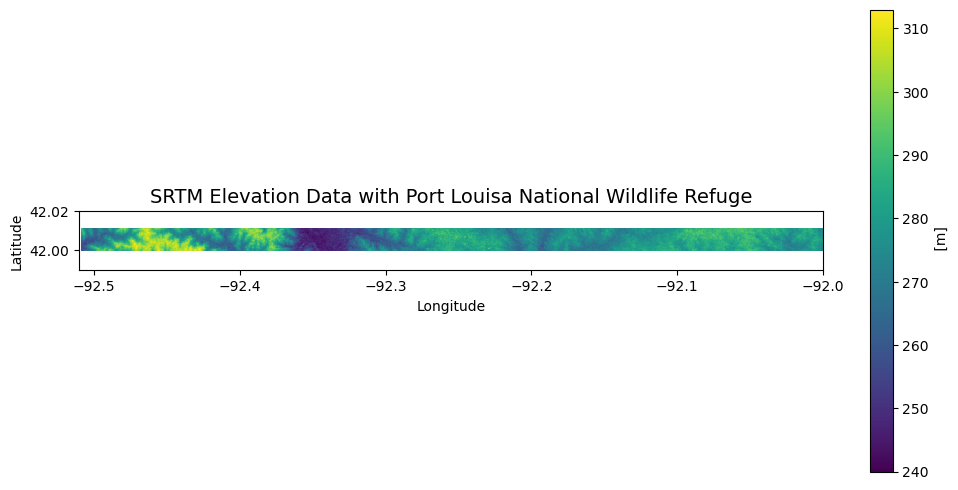

In [49]:
# Create a list
louisa_srtm_da_list = []

buffer_size = 0.05  # Adjust as needed
minx, miny, maxx, maxy = louisa_gdf.total_bounds

# Expand the bounding box slightly
expanded_bounds = (minx, miny - buffer_size, maxx, maxy + buffer_size)


# Check if any files match the pattern
srtm_files = glob(louisa_srtm_pattern)
print(f"Found {len(srtm_files)} SRTM files")

if not srtm_files:
    raise FileNotFoundError("No SRTM files found. Check the file path pattern.")

for louisa_srtm_path in srtm_files:
    louisa_tile_da = rxr.open_rasterio(louisa_srtm_path, mask_and_scale=True).squeeze()

print("Raster Extent:", louisa_tile_da.rio.bounds())
print("Bounding Box:", bounds_louisa_buffer)
    
    # Crop data arrays
louisa_cropped_da = louisa_tile_da.rio.clip_box(*expanded_bounds, auto_expand=True)
louisa_srtm_da_list.append(louisa_cropped_da)

# Ensure we have data before merging
if louisa_srtm_da_list:
    louisa_srtm_da = rxrmerge.merge_arrays(louisa_srtm_da_list)
else:
    raise ValueError("No valid raster data found to merge.")

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))  # Wider aspect ratio because my data is very long

# Plot the DataArray
louisa_srtm_da.plot(ax=ax)

# louisa_srtm_da.plot(ax=ax, aspect=1.5)  # Adjust as needed


# Plot the habitat1 boundary on the same axis
louisa_gdf.boundary.plot(ax=ax, color='yellow', linewidth=0.5)

# Add a title and axis labels
ax.set_title('SRTM Elevation Data with Port Louisa National Wildlife Refuge', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_xlim(-92.51, -92.0)
ax.set_ylim(41.99, 42.02)

# Display the plot
plt.show()


In [50]:
# Reproject and calculate slope 
# Find the UTM zone using https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#
# Port Louisa is in UTM 15
utm15_epsg = 32615
louisa_srtm_project_da = louisa_srtm_da.rio.reproject(32615)
louisa_proj_gdf = louisa_gdf.to_crs(utm15_epsg)

# Calculate slope
louisa_slope_full_da = xrspatial.slope(louisa_srtm_project_da)

# Clip the slope data by the Port Louisa's boundaries
louisa_slope_da = louisa_slope_full_da.rio.clip(louisa_proj_gdf.geometry)

# Create a figure and axes to ensure consistent plotting
fig, ax = plt.subplots(figsize=(12, 6))  # Wider aspect ratio because my data is very long

# Plot the slope data
louisa_slope_da.plot(ax=ax, cmap='terrain')

# Add a title and labels after plotting
ax.set_title('SRTM Elevation Data of Port Louisa', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()

NoDataInBounds: No data found in bounds. Data variable: slope

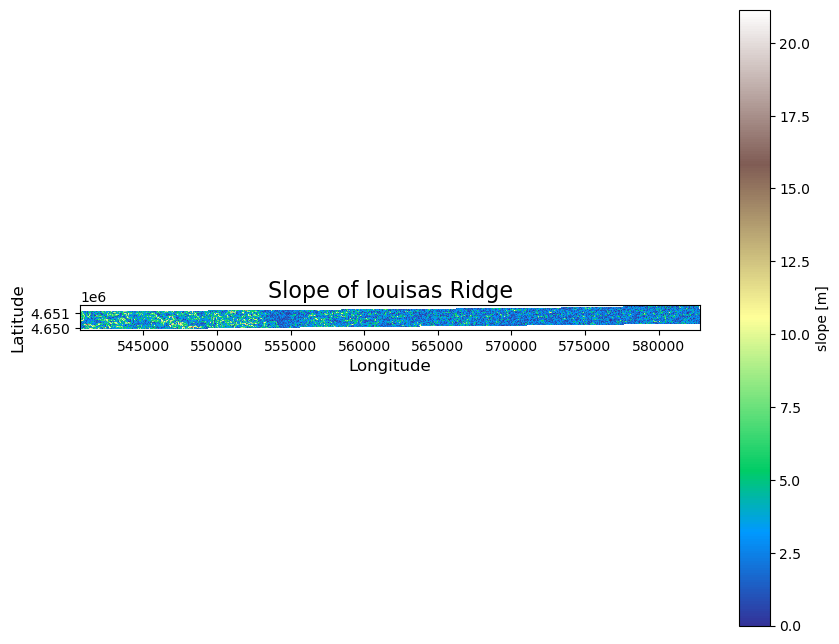

In [51]:
# Calculate the slope
louisa_slope_da = xrspatial.slope(louisa_srtm_project_da)

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust the figure size

# Plot the slope on the specified axis
louisa_slope_da.plot(ax=ax, cmap='terrain')

# Add the Habitat 1 boundary
louisa_gdf.to_crs(utm15_epsg).boundary.plot(ax=ax, color='yellow', linewidth=.5)

# Add a title and labels
ax.set_title('Slope of louisas Ridge', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Display the plot
plt.show()



In [53]:
# Store the essential information to import into the next notebook
%store louisa_gdf louisa_srtm_da

Stored 'louisa_gdf' (GeoDataFrame)
Stored 'louisa_srtm_da' (DataArray)
